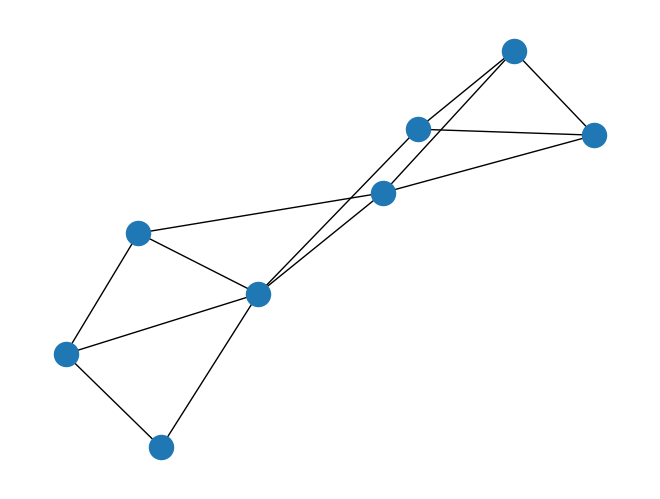

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# ensure reproducibility
#seed = 10
#np.random.seed(seed)

n_nodes = 8
edge_prob = 0.5
graph = nx.gnp_random_graph(n_nodes, edge_prob)

nx.draw(graph)


# Problem (Maximal Cut)

Find the partition $p$ of the graph that maximizes the number of edges between the two subgraphs.

Formally, maximize:

$$\mathcal{C}(p) = \sum_{\alpha \in edges} \mathcal{C}_{\alpha}(p)$$

where:

- $\mathcal{C}_{\alpha}(p)$ is $0$ if the nodes connected by edge $\alpha$ are in the same set, as defined by $p$;
- $\mathcal{C}_{\alpha}(p)$ is $1$ if the nodes connected by edge $\alpha$ are in distinct sets, as defined by $p$.

In [4]:
# Derive a circuit from the graph.

from qadence import Zero, I, HamEvo, tag, kron, chain, QuantumCircuit, RX, Z

# generators associated with the edges of the given graph
zz_ops = [kron(Z(edge[0]), Z(edge[1])) for edge in graph.edges()]
print(f"converted the graph into {len(zz_ops)} gates")

n_qubits = graph.number_of_nodes()
n_layers = 2

cost_ham = Zero()
for op in zz_ops:
    cost_ham += 0.5 * op
cost_ham = 0.5 * kron(I(i) for i in range(n_qubits)) - cost_ham

layers = []
for layer in range(n_layers):

    # cost layer with digital decomposition
    cost_layer = HamEvo(cost_ham, f"g{layer}").digital_decomposition()
    cost_layer = tag(cost_layer, "cost")

    # mixing layer with single qubit rotations
    mixing_layer = kron(RX(i, f"b{layer}{i}") for i in range(n_qubits))
    mixing_layer = tag(mixing_layer, "mixing")

    # putting all together in a single ChainBlock
    layers.append(chain(cost_layer, mixing_layer))

final_b = chain(*layers)

circuit = QuantumCircuit(n_qubits, final_b)



converted the graph into 13 gates


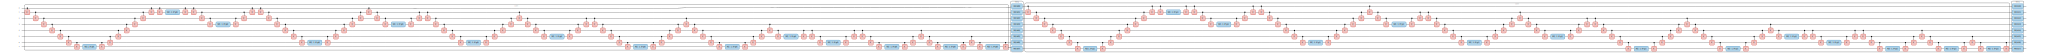

In [5]:
from qadence.draw import display
display(circuit)

In [6]:
# A loss function, which the optimizer will use to pick a good solution.

import torch
from qadence import QuantumModel

torch.manual_seed(seed)


def loss_function(_model: QuantumModel):

    expval_ops = _model.expectation().squeeze()

    # this corresponds to the MaxCut cost by definition
    # with negative sign in front to perform maximization
    expval = 0.0
    for val in expval_ops:
        expval += 0.5 * (1 - val)

    return -1.0 * expval

In [7]:
# Train the model.

# initialize the parameters to random values
model = QuantumModel(circuit, observable=zz_ops)
model.reset_vparams(torch.rand(model.num_vparams))
initial_loss = loss_function(model)
print(f"Initial loss: {initial_loss}")

# train the model
n_epochs = 100
lr = 1.0

optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

# run a few optimization steps
for i in range(n_epochs):
    optimizer.zero_grad()
    loss = loss_function(model)
    loss.backward()
    optimizer.step()
    if (i+1) % (n_epochs // 10) == 0:
        print(f"MaxCut cost at iteration {i+1}: {-loss.item()}")

Initial loss: -3.3003692821636337
MaxCut cost at iteration 10: 8.003027994264889
MaxCut cost at iteration 20: 9.561500047629472
MaxCut cost at iteration 30: 9.999652377637446
MaxCut cost at iteration 40: 9.999999788600189
MaxCut cost at iteration 50: 9.999999993433287
MaxCut cost at iteration 60: 9.999999999767034
MaxCut cost at iteration 70: 9.99999999999173
MaxCut cost at iteration 80: 9.999999999999707
MaxCut cost at iteration 90: 9.999999999999988
MaxCut cost at iteration 100: 9.999999999999991


Most frequently sampled bitstring corresponding to the maximum cut: 11000101


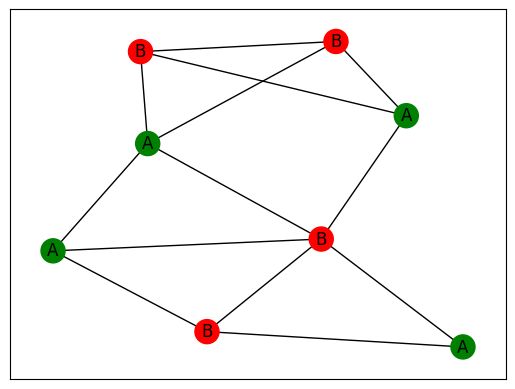

In [8]:
# Display the result.

samples = model.sample(n_shots=100)[0]
most_frequent = max(samples, key=samples.get)

print(f"Most frequently sampled bitstring corresponding to the maximum cut: {most_frequent}")

# let's now draw the cut obtained with the QAOA procedure
colors = []
labels = {}
for node, b in zip(graph.nodes(), most_frequent):
    colors.append("green") if int(b) == 0 else colors.append("red")
    labels[node] = "A" if int(b) == 0 else "B"

nx.draw_networkx(graph, node_color=colors, with_labels=True, labels=labels)